In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/test.zip data/
!cp drive/MyDrive/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

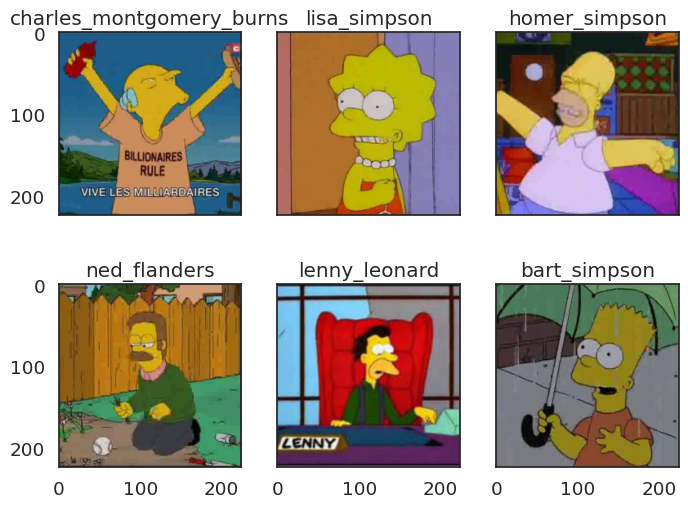

In [ ]:
show_images(val_dataset)

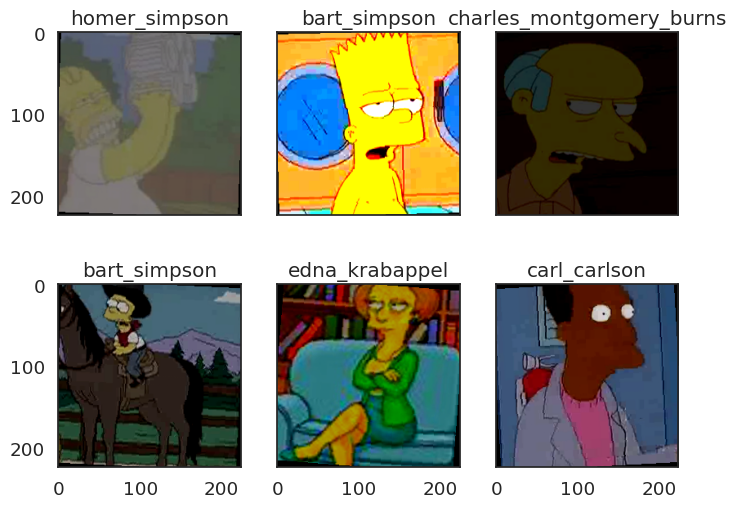

In [ ]:
show_images(train_dataset)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    scheduler,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import resnet18

###Проведем первый эксперимент с шедулером ExponentialLR

Epoch 10 of 10 took 165.336s
  training loss (in-iteration): 	2.111803
  validation loss (in-iteration): 	1.869609
  training accuracy: 			42.01 %
  validation accuracy: 			49.56 %


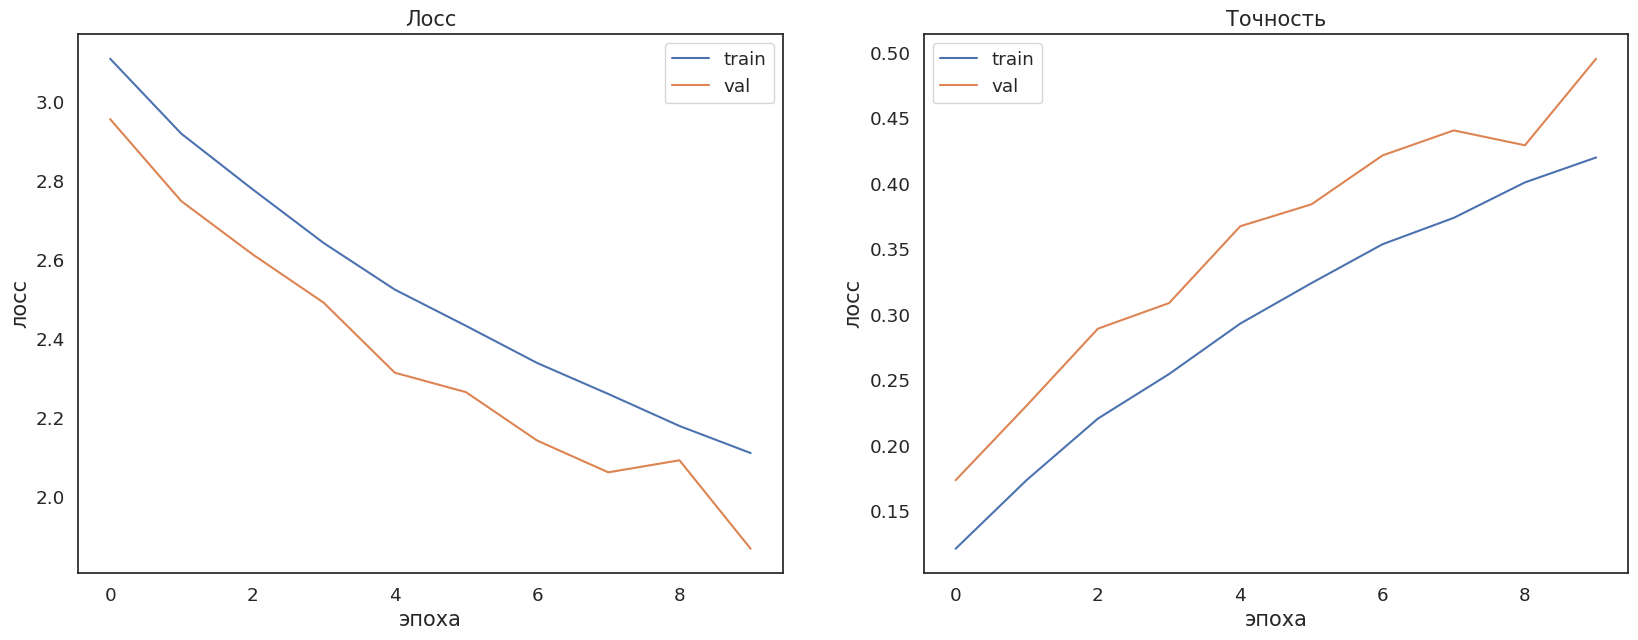

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

###Проведем второй эксперемент с шедулер PolynomialLR

Epoch 10 of 10 took 174.388s
  training loss (in-iteration): 	2.699238
  validation loss (in-iteration): 	2.559641
  training accuracy: 			24.65 %
  validation accuracy: 			31.66 %


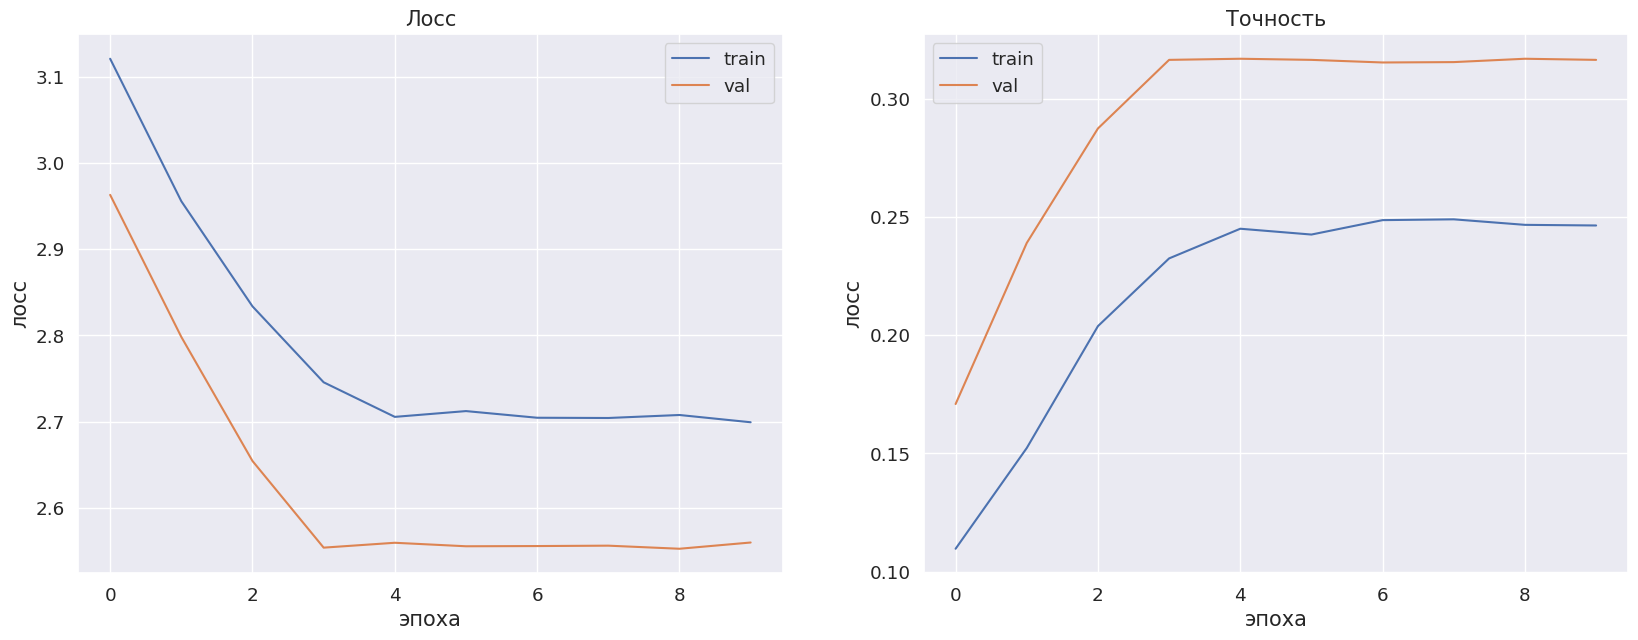

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=4, power=1.0)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

шедулер PolynomialLR плохо повлиял на качество обучения модели

###Применим трансформации посмотрим какой результат получим

Переведем изображения в оттенки серого и для 80% выполним вертикальный флип. Полученный датасет имеет мало общего с представлениями о реальном мире, метрики на валидационной выборке должны получиться сильно хуже

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomVerticalFlip(0.8),

    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

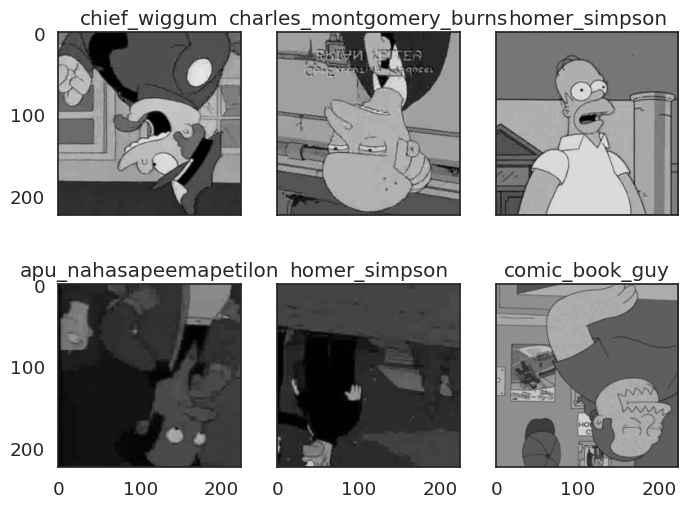

In [ ]:
show_images(train_dataset)

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 10 of 10 took 146.097s
  training loss (in-iteration): 	1.928856
  validation loss (in-iteration): 	4.202978
  training accuracy: 			49.36 %
  validation accuracy: 			9.64 %


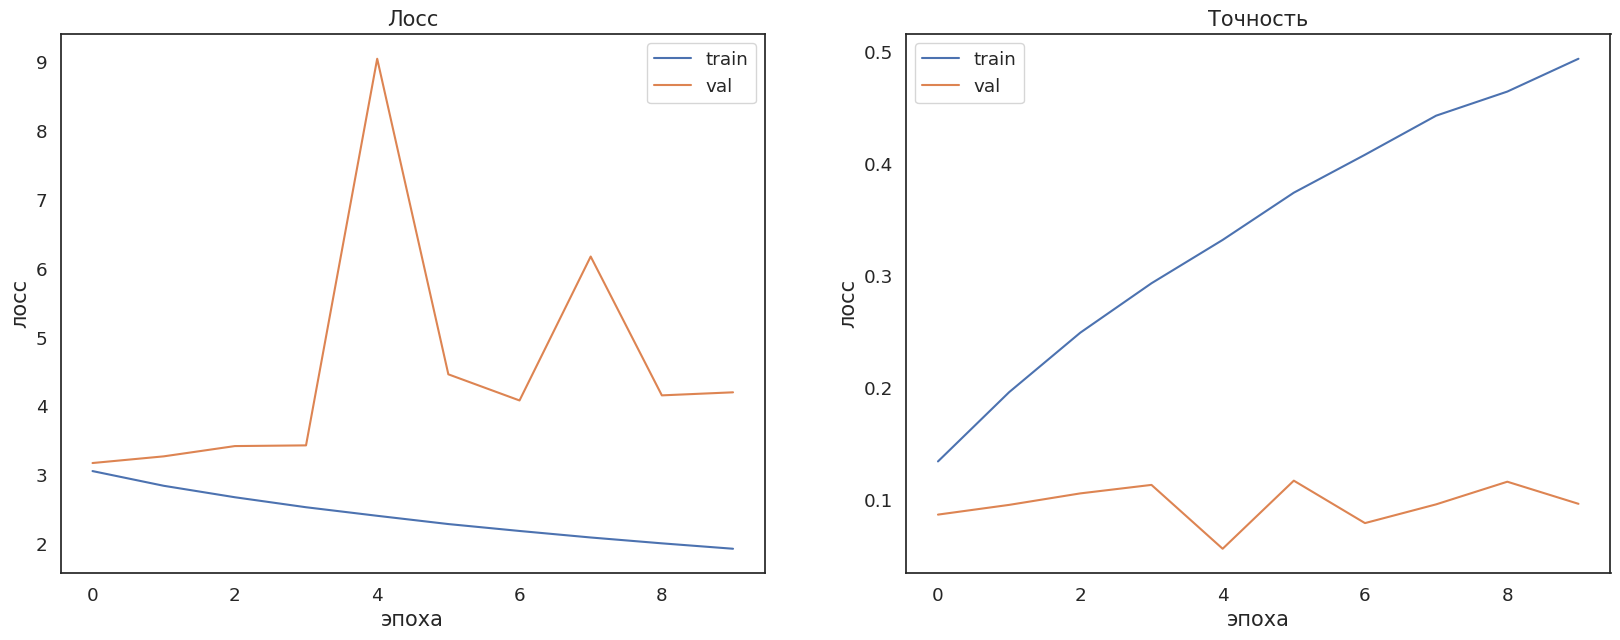

In [16]:


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

Наша гипотеза подтвердилась, на валидации получили низкую, нестабильную метрику

### MobileNet

Загрузим данные

In [17]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [18]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Обучение с нуля

In [19]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
model = mobilenet_v2(weights=None)

In [ ]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
model.classifier[1] = nn.Linear(1280, 42)

Epoch 10 of 10 took 185.923s
  training loss (in-iteration): 	2.301072
  validation loss (in-iteration): 	2.042704
  training accuracy: 			36.35 %
  validation accuracy: 			44.48 %


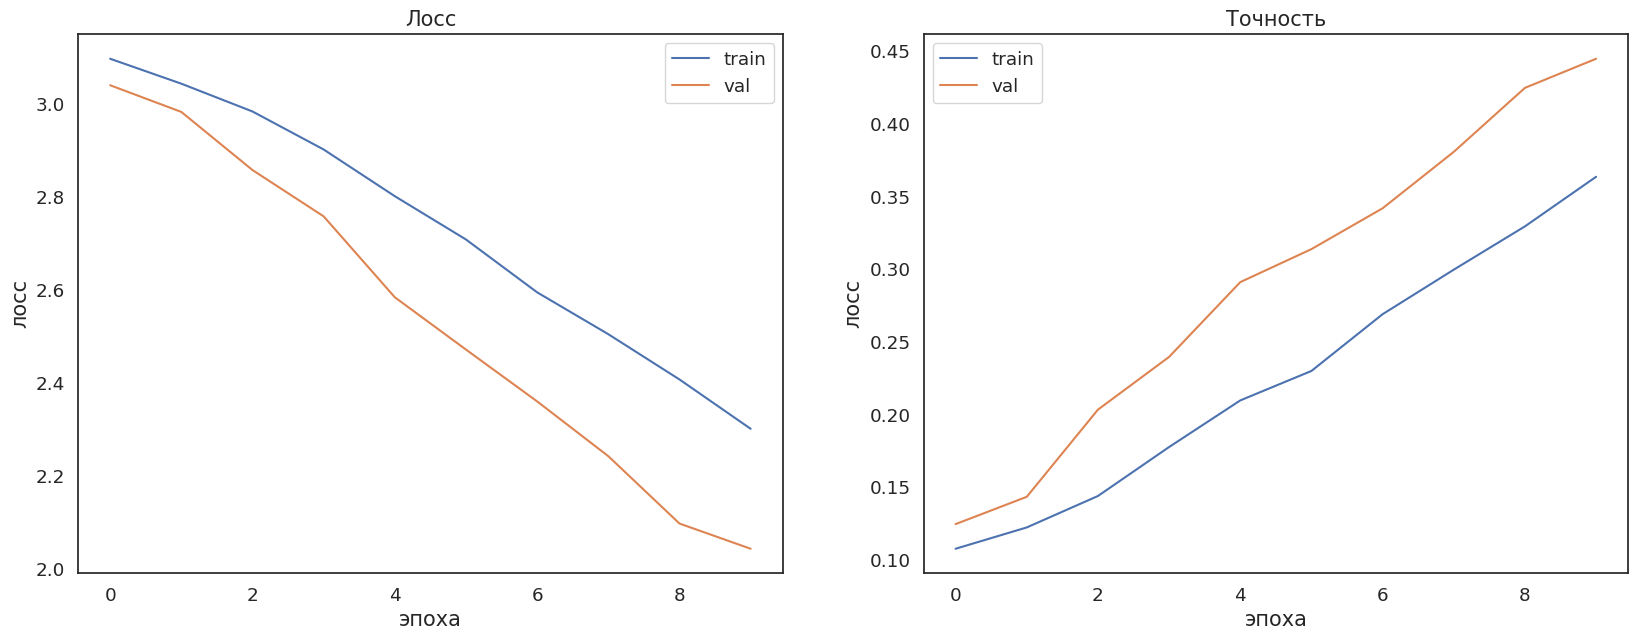

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

Используем модель как Feature Extractor

In [ ]:
fe_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 70.9MB/s]


In [ ]:
# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False


In [ ]:
fe_model.classifier[1] = nn.Linear(1280, 42)

Epoch 10 of 10 took 145.097s
  training loss (in-iteration): 	1.769167
  validation loss (in-iteration): 	1.438794
  training accuracy: 			55.57 %
  validation accuracy: 			65.99 %


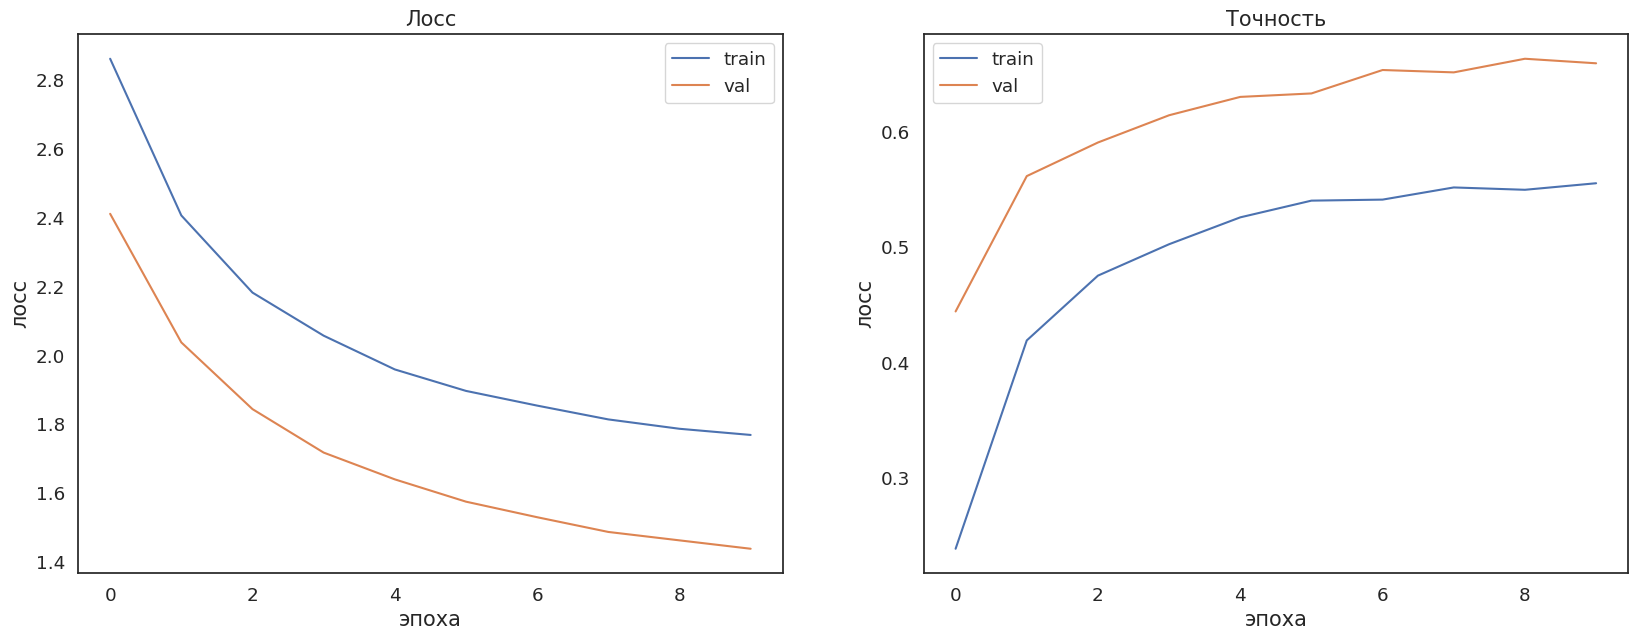

In [ ]:
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)

Используем модель, как Fine Tuning

In [20]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilent', mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))




Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 82.8MB/s]


Epoch 10 of 10 took 183.918s
  training loss (in-iteration): 	0.118327
  validation loss (in-iteration): 	0.189838
  training accuracy: 			97.14 %
  validation accuracy: 			95.33 %


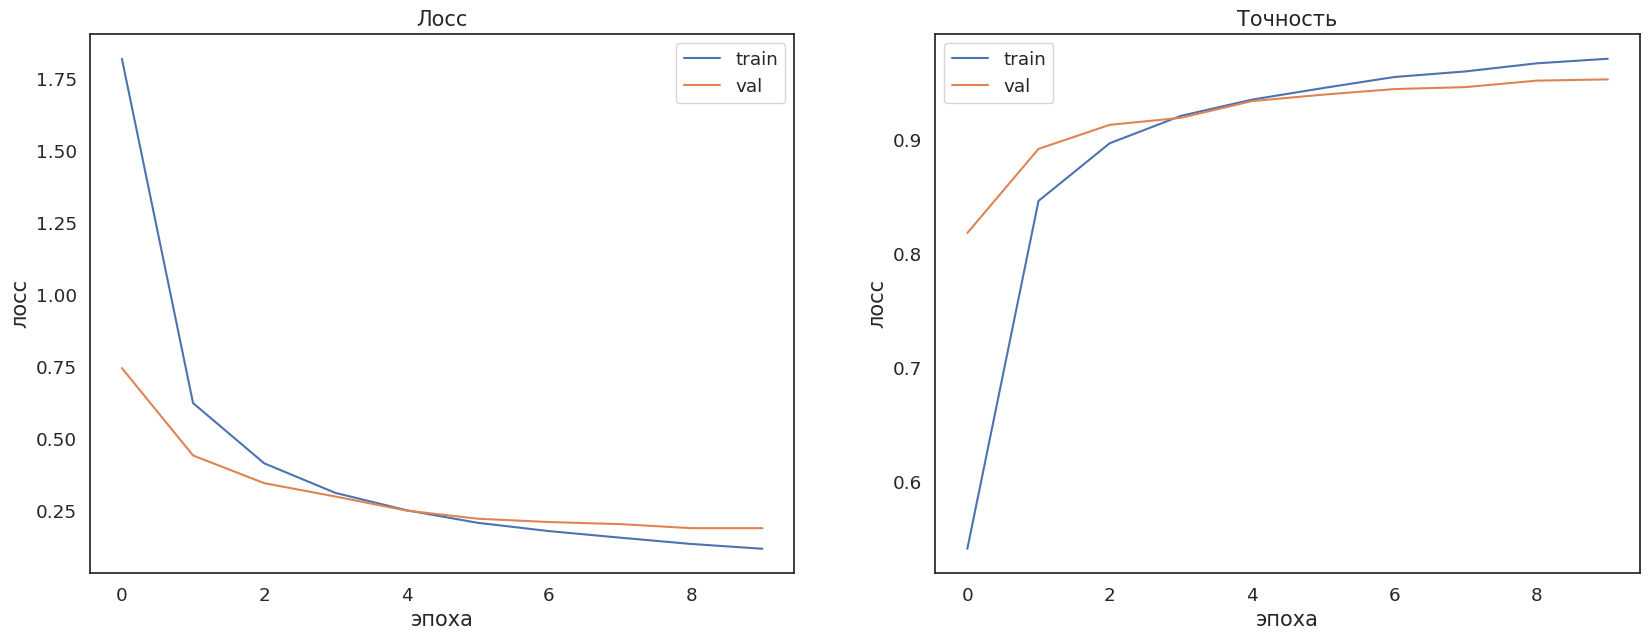

In [21]:
fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=10
)


### Вывод:
Обучили тремя способами модель Imagenet, по результатам обучения можем сделать следующие выводы:
- Обучение с нуля - есть перспектива к дальнейшему обучению и увеличению accuracy при увеличении эпох
- Использование модели как экстрактор признаков - обучение на восьмой эпохе выводит модель на плато, дальнейшего смысла в обучении модели нет. Accuracy довольно низкий - 65.99%
- Использование модели в режиме fine tuning - достаточно высокие метрики, но уже на 4-ой эпохе начинаем наблюдать признаки переобучения модели